In [63]:
import pandas as pd
import kaplanmeier as km
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import numpy as np
from Ensembl_converter import EnsemblConverter

# Create an instance of EnsemblConverter
converter = EnsemblConverter()

# Load the data

In [64]:
# TODO Replace this with the converted gene names
expression = pd.read_csv('GSE39582/GSE39582_Expression.txt', sep='\t')
expression = expression.rename(columns={'Unnamed: 0': 'SampleID'})
expression.head()

,SampleID,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000281692,ENSG00000281706,ENSG00000281732,ENSG00000281778,ENSG00000281831,ENSG00000281912,ENSG00000281937,ENSG00000282021,ENSG00000282408,ENSG00000282742
0,GSM971957,2.110198,0.297104,2.540870,0.840843,0.317806,0.647407,0.472394,1.634555,0.991131,...,-0.102991,-0.242896,0.092574,0.159464,0.014149,0.093481,-0.110161,-0.165282,-0.113612,-0.021521
1,GSM971958,2.691806,0.033531,2.760942,0.444017,0.457403,1.004509,1.551471,1.669845,1.010561,...,-0.211863,-0.300486,0.073052,0.093688,-0.148147,0.045771,-0.120700,-0.206608,-0.130290,-0.057759
2,GSM971959,2.309938,-0.148700,2.495403,0.367560,0.380946,0.312816,0.087595,1.357618,0.885281,...,-0.047195,-0.236847,0.221524,0.008524,0.004061,0.015774,-0.161790,-0.160966,0.913928,-0.049035
3,GSM971960,3.404085,0.270825,2.632237,0.618470,0.364756,0.454825,0.413661,1.618976,1.073774,...,0.008664,-0.167635,0.058125,0.137901,-0.074995,0.042816,-0.077133,-0.194407,-0.093525,-0.136959
4,GSM971961,2.245160,-0.081983,2.545356,0.617706,0.312654,1.477605,1.105855,1.552995,0.949125,...,-0.173737,-0.182521,0.063194,0.109615,-0.110598,-0.017879,-0.046757,-0.248188,-0.164532,-0.015418


In [65]:
clinical = pd.read_csv('GSE39582/GSE39582_Clinical.txt', sep='\t')
clinical.head()

,SampleID,age.at.diagnosis_year,braf.mutation,chemotherapy.adjuvant,chemotherapy.adjuvant.type,cimp.status,cin.status,cit.molecularsubtype,dataset,dependancy_sample,...,Sex,tnm.m,tnm.n,tnm.stage,tnm.t,tp53.mutation,tp53.mutation.dna,tp53.mutation.exon.number,tp53.mutation.protein,tumor.location
0,GSM971957,34.5,WT,N,NaN,-,+,C5,discovery,NaN,...,Male,M1,N2,4.0,T4,M,NaN,NaN,NaN,distal
1,GSM971958,36.4,WT,N,NaN,-,-,C4,discovery,NaN,...,Female,M1,N2,4.0,T3,WT,NaN,NaN,NaN,distal
2,GSM971959,36.9,WT,N,NaN,-,-,C3,discovery,NaN,...,Male,M0,N0,2.0,T4,M,NaN,NaN,NaN,proximal
3,GSM971960,38.2,WT,N,NaN,-,+,C1,discovery,NaN,...,Female,M0,N0,1.0,T2,M,NaN,NaN,NaN,distal
4,GSM971961,39.2,WT,Y,NaN,-,NaN,C4,discovery,NaN,...,Female,M1,N1,4.0,T3,M,NaN,NaN,NaN,distal


# Preprocess the data

In [66]:
def plot_expression_histograms(expression_df):
    _, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i, gene in enumerate(expression_df.columns):
        sns.histplot(expression_df[gene], bins=50, ax=axs[i//2, i%2])
        axs[i//2, i%2].set_xlabel('Values')
        axs[i//2, i%2].set_ylabel('Frequency')
        axs[i//2, i%2].set_title(f'Histogram of {gene} expression values')
    plt.show()

In [67]:
# Select the columns of interest
ensg_list = ["ENSG00000153563", "ENSG00000173372", "ENSG00000173369", "ENSG00000159189"]
selected_expression = expression.loc[:, expression.columns.isin(ensg_list)]

# Convert the ENSG to gene names
selected_expression = selected_expression.set_axis(converter.convert_ids(selected_expression.columns.to_list())["Symbol"], axis=1)
selected_expression.head()

Symbol,CD8A,C1QC,C1QB,C1QA
0,0.596124,1.997896,1.903742,1.562382
1,0.624260,1.985117,2.073362,1.880654
2,0.097797,1.838926,1.876966,1.608621
3,0.366074,1.625091,1.448147,1.462362
4,0.307417,2.953093,3.432946,3.331355


## Normalize the data

In [68]:
counts_expression = selected_expression.apply(lambda x: np.power(2, x))
counts_expression.head()

Symbol,CD8A,C1QC,C1QB,C1QA
0,1.511650,3.994171,3.741824,2.953410
1,1.541420,3.958947,4.208662,3.682419
2,1.070138,3.577436,3.673019,3.049602
3,1.288841,3.084616,2.728573,2.755592
4,1.237490,7.744075,10.799899,10.065557


In [69]:
counts_expression = pd.concat([expression['SampleID'], counts_expression], axis=1)
counts_expression.head()

,SampleID,CD8A,C1QC,C1QB,C1QA
0,GSM971957,1.511650,3.994171,3.741824,2.953410
1,GSM971958,1.541420,3.958947,4.208662,3.682419
2,GSM971959,1.070138,3.577436,3.673019,3.049602
3,GSM971960,1.288841,3.084616,2.728573,2.755592
4,GSM971961,1.237490,7.744075,10.799899,10.065557


# Calculate and plot SIA

In [70]:
def format_data(expression: pd.DataFrame, C1QX: str) -> pd.DataFrame:
    """Formats the data for the SIA calculation and categorization

    Args:
        expression (pd.Dataframe): Contains the expression data
        genes (list[str]): List of genes to be used for the SIA calculation

    Returns:
        pd.Dataframe: Dataframe with the SIA and SIA-category {C1QX} columns
    """    
    expression[f"SIA-category {C1QX}"] = pd.qcut(expression[f"SIA {C1QX}"], 3, labels=["Low SIA", "Intermediate SIA", "High SIA"])
    return expression.dropna()

In [71]:
def get_log_rank_p(expression: pd.DataFrame, C1QX: str) -> tuple[float, float]:
    """Calculates the log-rank p-value for the SIA categories

    Args:
        expression (pd.DataFrame): Dataframe containing the SIA and SIA-category columns
        
    Returns:
        tuple[float, float]: Log-rank p-values for high vs intermediate and intermediate vs low
    """
    # Partition data
    expression_high_intermediate = expression[((expression[f"SIA-category {C1QX}"] == "High SIA" ) | (expression[f"SIA-category {C1QX}"] == "Intermediate SIA"))]
    expression_intermediate_low = expression[((expression[f"SIA-category {C1QX}"] == "Intermediate SIA" ) | (expression[f"SIA-category {C1QX}"] == "Low SIA"))]
    
    # Calculate log-rank p-value for high vs intermediate
    time_high_intermediate = expression_high_intermediate["os.delay"]
    event_high_intermediate = expression_high_intermediate["os.event"]
    group_high_intermediate = expression_high_intermediate[f"SIA-category {C1QX}"]
    results_high_intermediate = km.fit(time_high_intermediate, event_high_intermediate, group_high_intermediate)
    log_rank_p_high_intermediate = results_high_intermediate["logrank_P"]
    
    # Calculate log-rank p-value for intermediate vs low
    time_intermediate_low = expression_intermediate_low["os.delay"]
    event_intermediate_low = expression_intermediate_low["os.event"]
    group_intermediate_low = expression_intermediate_low[f"SIA-category {C1QX}"]
    results_intermediate_low = km.fit(time_intermediate_low, event_intermediate_low, group_intermediate_low)
    log_rank_p_intermediate_low = results_intermediate_low["logrank_P"]    
    
    return log_rank_p_high_intermediate, log_rank_p_intermediate_low

In [72]:
def plot_survival_curve(
    expression: pd.DataFrame, 
    log_rank_p_high_intermediate: float, 
    log_rank_p_intermediate_low: float,
    C1QX: str
    ) -> None:
    """Plots the survival curve for the SIA categories

    Args:
        expression (pd.DataFrame): Dataframe containing the SIA and SIA-category columns
    """
    high_intermediate_label = f"High vs Intermediate (p = {log_rank_p_high_intermediate:.3f})"
    intermediate_low_label = f"Intermediate vs Low (p = {log_rank_p_intermediate_low:.3f})"
    plot_title = f"Survival curve for SIA categories " + f"({high_intermediate_label}, {intermediate_low_label})"
    time = expression["os.delay"]
    event = expression["os.event"]
    group = expression[f"SIA-category {C1QX}"]
    results = km.fit(time, event, group)
    km.plot(
        results,
        title=plot_title,
        )

In [73]:
# Calculate SIA
for C1QX in counts_expression.columns[2:]:
    counts_expression[f"SIA {C1QX}"] = counts_expression["CD8A"] / counts_expression[C1QX]
counts_expression.head()

,SampleID,CD8A,C1QC,C1QB,C1QA,SIA C1QC,SIA C1QB,SIA C1QA
0,GSM971957,1.511650,3.994171,3.741824,2.953410,0.378464,0.403987,0.511832
1,GSM971958,1.541420,3.958947,4.208662,3.682419,0.389351,0.366249,0.418589
2,GSM971959,1.070138,3.577436,3.673019,3.049602,0.299135,0.291351,0.350911
3,GSM971960,1.288841,3.084616,2.728573,2.755592,0.417829,0.472350,0.467718
4,GSM971961,1.237490,7.744075,10.799899,10.065557,0.159798,0.114584,0.122943


In [74]:
# Merge with clinical and select wanted columns
counts_expression = counts_expression.merge(clinical, on='SampleID')
selected_columns = counts_expression.columns[:8].to_list() + ["os.delay", "os.event"]
survivalplot_data = counts_expression[selected_columns]
survivalplot_data.head()

,SampleID,CD8A,C1QC,C1QB,C1QA,SIA C1QC,SIA C1QB,SIA C1QA,os.delay,os.event
0,GSM971957,1.511650,3.994171,3.741824,2.953410,0.378464,0.403987,0.511832,10.0,1.0
1,GSM971958,1.541420,3.958947,4.208662,3.682419,0.389351,0.366249,0.418589,9.0,1.0
2,GSM971959,1.070138,3.577436,3.673019,3.049602,0.299135,0.291351,0.350911,52.0,0.0
3,GSM971960,1.288841,3.084616,2.728573,2.755592,0.417829,0.472350,0.467718,74.0,0.0
4,GSM971961,1.237490,7.744075,10.799899,10.065557,0.159798,0.114584,0.122943,32.0,1.0


In [77]:
survivalplot_data.columns[2:5]

Index(['C1QC', 'C1QB', 'C1QA'], dtype='object')

C1QC


C:\Users\victo\AppData\Local\Temp\ipykernel_37548\411466930.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expression[f"SIA-category {C1QX}"] = pd.qcut(expression[f"SIA {C1QX}"], 3, labels=["Low SIA", "Intermediate SIA", "High SIA"])


C1QB
C1QA


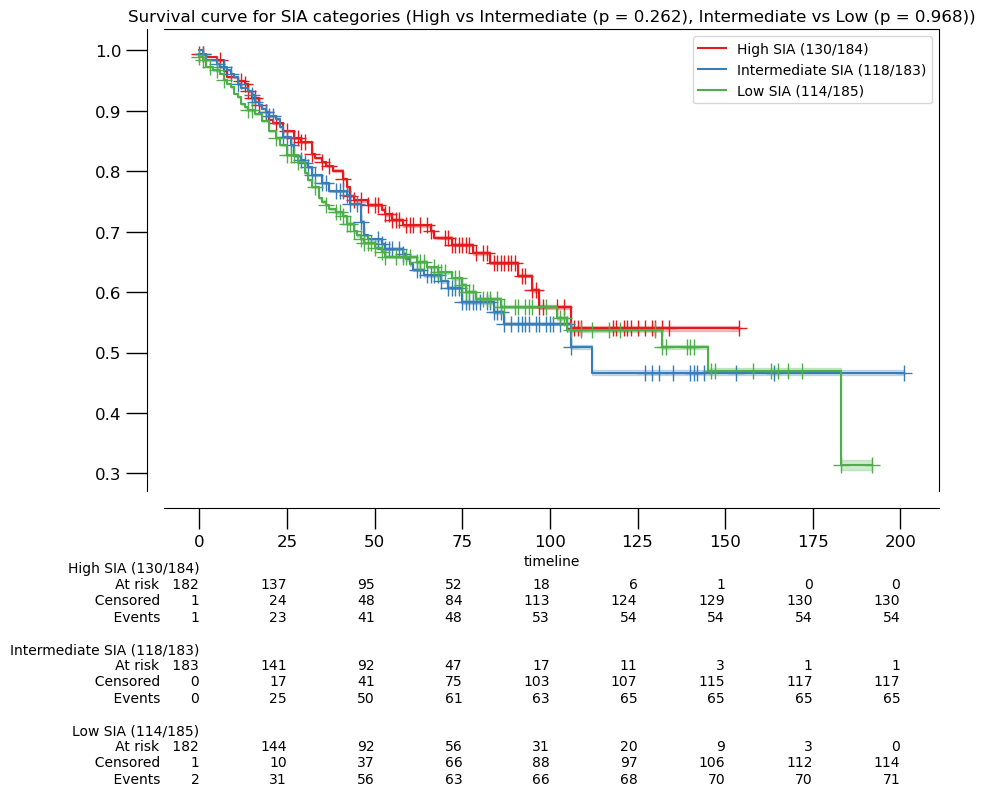

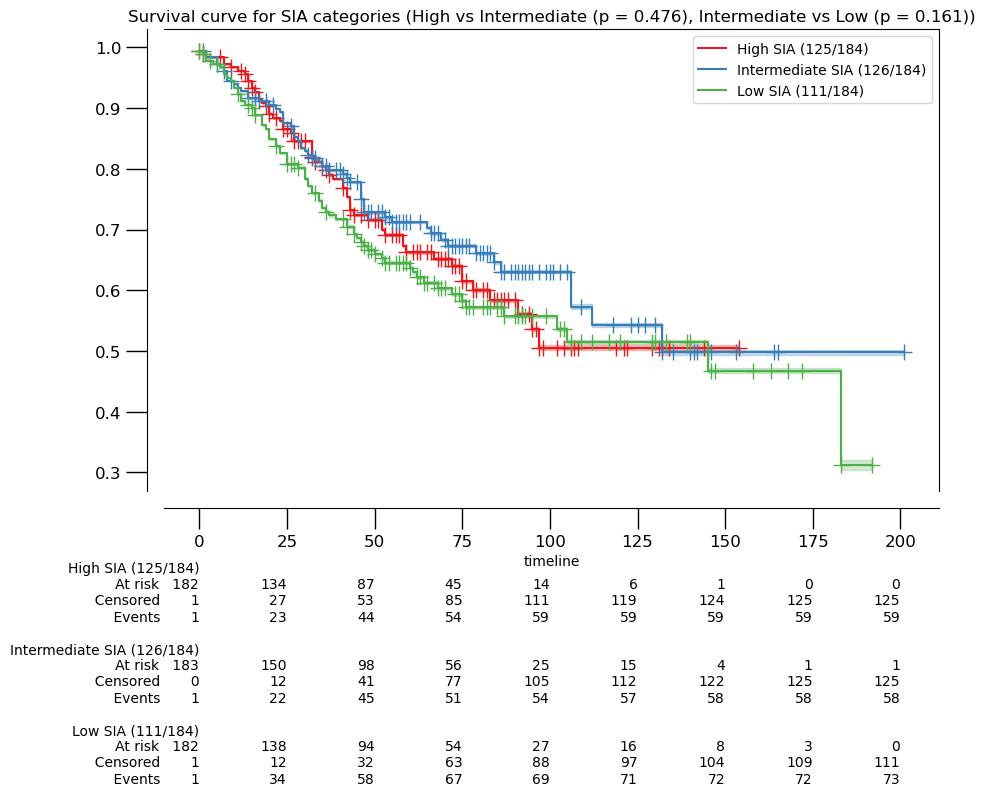

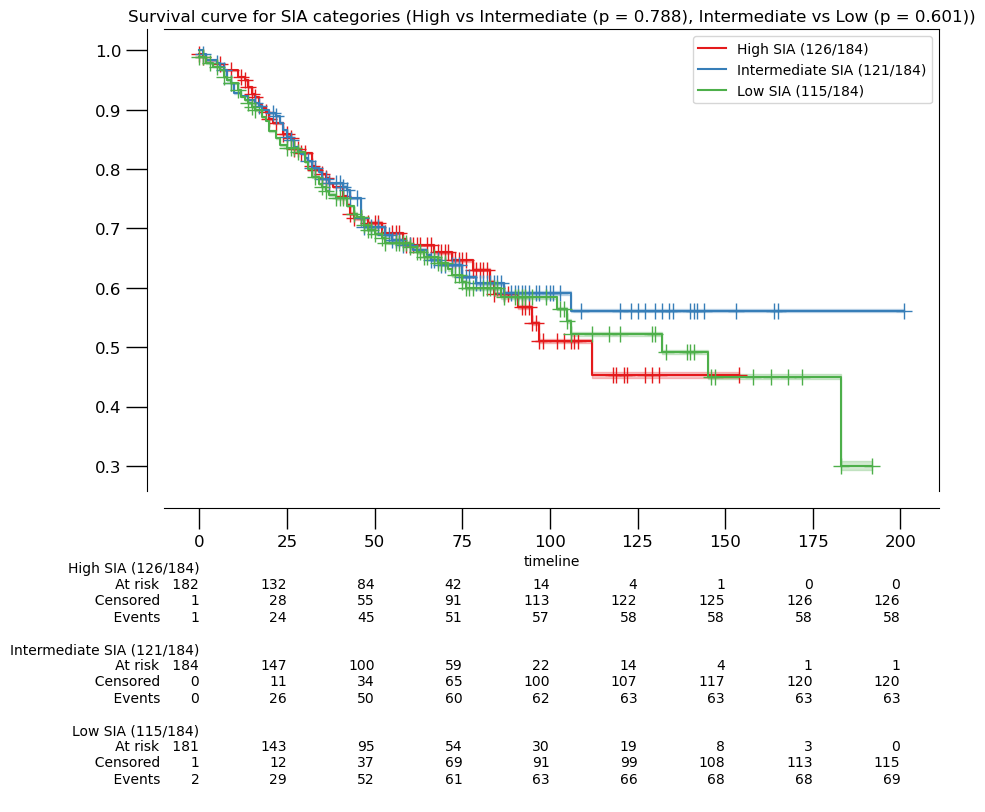

In [78]:
for C1QX in survivalplot_data.columns[2:5]:
    survivalplot_data = format_data(survivalplot_data, C1QX)
    log_rank_p_high_intermediate, log_rank_p_intermediate_low = get_log_rank_p(survivalplot_data, C1QX)
    plot_survival_curve(survivalplot_data, log_rank_p_high_intermediate, log_rank_p_intermediate_low, C1QX)

In [79]:
survivalplot_data

,SampleID,CD8A,C1QC,C1QB,C1QA,SIA C1QC,SIA C1QB,SIA C1QA,os.delay,os.event,SIA-category C1QC,SIA-category C1QB,SIA-category C1QA
0,GSM971957,1.511650,3.994171,3.741824,2.953410,0.378464,0.403987,0.511832,10.0,1.0,Low SIA,Low SIA,Intermediate SIA
1,GSM971958,1.541420,3.958947,4.208662,3.682419,0.389351,0.366249,0.418589,9.0,1.0,Low SIA,Low SIA,Low SIA
2,GSM971959,1.070138,3.577436,3.673019,3.049602,0.299135,0.291351,0.350911,52.0,0.0,Low SIA,Low SIA,Low SIA
3,GSM971960,1.288841,3.084616,2.728573,2.755592,0.417829,0.472350,0.467718,74.0,0.0,Low SIA,Intermediate SIA,Low SIA
4,GSM971961,1.237490,7.744075,10.799899,10.065557,0.159798,0.114584,0.122943,32.0,1.0,Low SIA,Low SIA,Low SIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,GSM972119,1.186994,1.699852,2.161583,2.064967,0.698293,0.549132,0.574825,37.0,0.0,High SIA,Intermediate SIA,Intermediate SIA
552,GSM972120,1.640882,2.877182,5.025003,4.090026,0.570309,0.326543,0.401191,36.0,0.0,Intermediate SIA,Low SIA,Low SIA
553,GSM972122,1.070104,1.286630,1.385078,1.343984,0.831711,0.772595,0.796218,19.0,1.0,High SIA,High SIA,High SIA
554,GSM972123,1.209567,1.409186,1.569776,1.608243,0.858344,0.770535,0.752104,71.0,0.0,High SIA,High SIA,High SIA


# Correlation study of C1QX

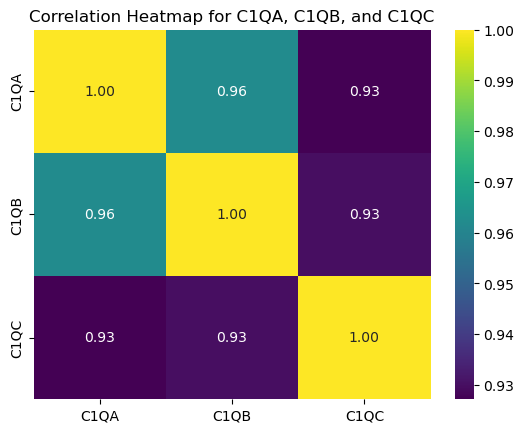

In [ ]:
# Selecting only the columns of interest
selected_columns = quantile_normalized_expression[['C1QA', 'C1QB', 'C1QC']]

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title('Correlation Heatmap for C1QA, C1QB, and C1QC')
plt.show()